In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchscale.architecture.config import EncoderConfig
from torchscale.architecture.encoder import Encoder
from functools import partial
import numpy as np
import pandas as pd
import os
import json
import re
from tqdm import tqdm
from fastai.vision.all import *
import fastai
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from Train import seed_everything, mse_loss, get_direction, mean_angular_error, base_model, pad_dataframe 
%config InlineBackend.figure_format = 'svg'

In [2]:
seed_everything(37)

In [3]:
dataframes = []
attn_list = []
for batch in tqdm(range(231,241)):
    for event in range(1000):
        data = pd.read_feather(f'./ve_10_100TeV/batch{batch}/event_{event}.feather') # single hit raw data saved in feather file
        #data = data.sample(frac=0.30, random_state=26) # take out 70% of signal
        #data['t0'] += np.random.normal(loc=0, scale=1, size=data.shape[0])  # Generate Gaussian noise, Add the noise to the 'time' column
        data = data.groupby('DomId').agg({'x0': 'first', 'y0': 'first', 'z0': 'first', 't0': 'min', 'e0': 'count'}).rename(columns={'e0': 'charge'}).reset_index().sort_values(by='t0').drop(columns=['DomId'])
        data, L = pad_dataframe(data, 196)
        dataframes.append(data)
        attn_mask = torch.zeros(196, dtype=torch.bool)
        attn_mask[:L] = True
        attn_list.append(attn_mask)

all_df = pd.concat(dataframes,ignore_index=True) 

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, data, attn_list):
        self.data = data
        self.attn_list = attn_list
    def __len__(self):
        return len(self.attn_list)  # Total number of data files
    def __getitem__(self, idx):
        # Fetch a single data point from the DataFrame
        data_point = self.data.iloc[idx*196:(idx+1)*196]
        data_dict = {"x0": torch.tensor(data_point["x0"].values).float(),
            "y0": torch.tensor(data_point["y0"].values).float(),
            "z0": torch.tensor(data_point["z0"].values).float(),
            "t0": torch.tensor(data_point["t0"].values).float(),
            "charge": torch.tensor(data_point["charge"].values).float(),
            "mask": self.attn_list[idx]}
        return data_dict

100%|██████████| 10/10 [00:47<00:00,  4.73s/it]


In [4]:
test_set = TestDataset(all_df, attn_list)
dataloader =  torch.utils.data.DataLoader(test_set)
def load_predict(trained_model, path):
    model = trained_model()
    weight = torch.load(path)
    model.load_state_dict(weight['model'])
    model.eval()
    model.to("cuda")
    preds = torch.Tensor([]).to("cuda")

    for x in tqdm(dataloader):
        with torch.no_grad():
            x = {k: x[k].to("cuda") for k in x}
            preds = torch.cat((preds, model(x)), dim=0)

    return preds
preds1 = load_predict(base_model, './trained_model/models/model.pth')
preds = get_direction(preds1[:, 0],preds1[:, 1],preds1[:, 2])
preds.shape

100%|██████████| 10000/10000 [00:51<00:00, 194.84it/s]


torch.Size([10000, 2])

In [5]:
dir_lst = []
energy_lst = []
for batch in tqdm(range(231,241)):
    with open(f'./ve_10_100TeV/batch{batch}/mc_events.json', 'r') as jfile:
        target_data = json.load(jfile)
    
    dir_lst.extend([get_direction(torch.tensor(target_data[i]['particles_in'][0]['px']),
                                  torch.tensor(target_data[i]['particles_in'][0]['py']),
                                  torch.tensor(target_data[i]['particles_in'][0]['pz'])) for i in range(1000)])
    
    energy_lst.extend([np.sqrt(target_data[i]['particles_in'][0]['px']**2+
                            target_data[i]['particles_in'][0]['py']**2+
                            target_data[i]['particles_in'][0]['pz']**2)*1e-3 for i in range(1000)])
target = torch.stack(dir_lst)
target.shape


100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


torch.Size([10000, 2])

In [6]:
def angular_dist_score(az_true, zen_true, az_pred, zen_pred):
    # pre-compute all sine and cosine values
    scalar_prod = (torch.sin(zen_true)*torch.sin(zen_pred)*(torch.cos(az_true)*torch.cos(az_pred) + torch.sin(az_true)*torch.sin(az_pred)) + (torch.cos(zen_true)*torch.cos(zen_pred))).clip( -1, 1)
    return (torch.arccos(scalar_prod)).abs().float()

In [7]:
def plot_figure(preds, target):
    azi_true, zen_true, azi_pred, zen_pred = target[:, 0].to('cpu'), target[:, 1].to('cpu'), preds[:, 0].to('cpu'), preds[:, 1].to('cpu')
    # compare the angular error
    final = angular_dist_score(azi_true, zen_true, azi_pred, zen_pred).numpy()
    plt.figure(figsize=(10,5))
    
    plt.hist(
        final,
        bins = np.linspace(0,np.pi/18,21),
        histtype = 'step',
        label = f'mean: {np.mean(final)/np.pi*180:,.4f}',
        color = 'red'
    )
    plt.xticks(np.linspace(0,np.pi/4/4.5,10+1), ['0','1','2','3','4','5','6','7','8','9','10'])
    plt.xlabel("Angular distance"+" [deg.]")
    plt.ylabel('event number')
    plt.axvline(x=np.median(final), color='blue', linestyle='--',label=f'median: {np.median(final)/np.pi*180:,.4f}')
    plt.axvline(x=np.percentile(final,68), color='black', linestyle='--',label=f'68%: {np.percentile(final,68)/np.pi*180:,.4f}')
    plt.axvline(x=np.percentile(final,95), color='grey', linestyle='--',label=f'95%: {np.percentile(final,95)/np.pi*180:,.4f}')
    plt.legend()
    plt.show()

    # energy relared figure
    energy_lst1 = np.log(np.array(energy_lst))
    indices = np.argsort(energy_lst1)
    E_sorted = energy_lst1[indices]
    y_sorted = np.array(final/np.pi*180)[indices]
    
    num_bins = 9
    bin_edges = np.linspace(np.log(10), np.log(100), num_bins + 1)
    bin_indices = np.digitize(E_sorted, bins=bin_edges)
    # To store the median and percentile values
    medians = []
    lower_perc = []
    upper_perc = []
    # Calculate statistics for each bin
    for i in range(1, num_bins+1):
        bin_y_values = y_sorted[bin_indices == i]
        if len(bin_y_values) > 0:
            medians.append(np.median(bin_y_values))
            lower_perc.append(np.percentile(bin_y_values, 16))
            upper_perc.append(np.percentile(bin_y_values, 84))
    
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    fig = plt.figure(figsize=(10, 6))  
    gs = GridSpec(6, 1, figure=fig)  
    
    ax1 = fig.add_subplot(gs[:5, 0]) 
    ax1.errorbar(bin_centers, medians, 
                 yerr=[np.array(medians) - np.array(lower_perc), np.array(upper_perc) - np.array(medians)], 
                 fmt='o', capsize=5, label='Median and 68% region')

    ax1.set_xlim(np.log(10)-0.1,np.log(100)+0.1)
    
    ax1.set_ylabel('angular distance [deg.]')
    ax1.legend()
    ax1.tick_params(labelbottom=False)
    
    ax2 = fig.add_subplot(gs[5:, 0]) 
    e = np.log(np.array(energy_lst))
    ax2.hist(e,bins=np.linspace(np.log(10), np.log(100), 10),
        color='lightgrey',rwidth=0.8,alpha=0.5)
    ax2.set_ylim(0,1500)
    ax2.set_xlabel('Energy [GeV], log scale')
    ax2.set_xticks([np.log(10),np.log(10**1.5),np.log(100)])
    ax2.set_xticklabels([r'$10^4$', r'$10^{4.5}$', r'$10^5$'])
    ax2.set_ylabel('event number')

    plt.show()


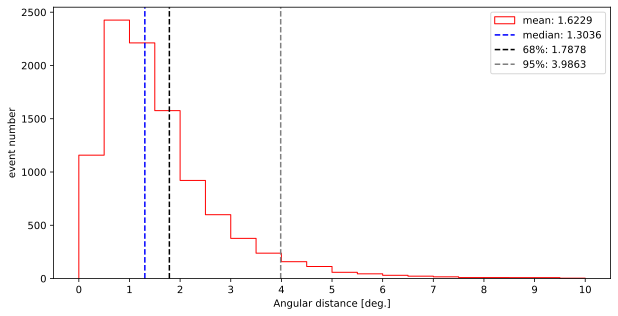

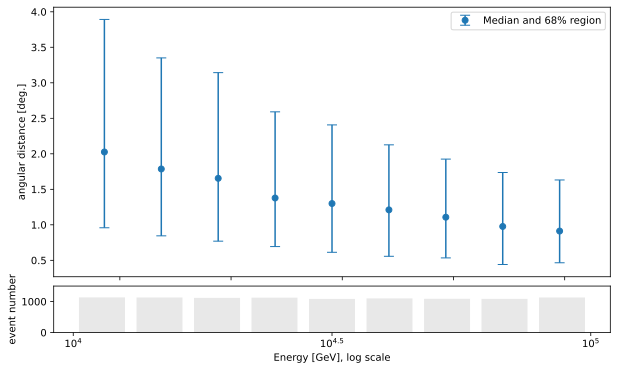

In [8]:
plot_figure(preds, target)